# Train Enocder-Only Optimal Trajectory Transformer Using Keras

In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Read data
T = 1
path = f"..\\data\\data_T{str(T)}.csv"
names = ['time', 'x1' , 'x2','obs_num']
df = pd.read_csv(path,sep=',', header=0, names=names,index_col=False)
print(df.head())
print(df.shape)

obs = max(df['obs_num'])
print("Number of different trajectory functions",int(obs))



       time        x1        x2  obs_num
0  0.000000  0.000000  0.000000      1.0
1  0.026316  0.021247  0.258732      1.0
2  0.052632  0.042495  0.510671      1.0
3  0.078947  0.063742  0.755816      1.0
4  0.105263  0.084990  0.994167      1.0
(11400, 4)
Number of different trajectory functions 300


In [2]:
# Train test split

train_data = df[df['time']< (0.7 * T)]
test_data = df[df['time']>= (0.7 * T)]
print("train shape, test shape: ",train_data.shape, test_data.shape)
print(train_data.head())

train_times = df[df['time']< (0.7 * T)]["time"].tolist()
test_times =  df[df['time']>= (0.7 * T)]["time"].tolist()
# print("train times: ", train_times)
# print("test times: ", test_times)

train shape, test shape:  (8100, 4) (3300, 4)
       time        x1        x2  obs_num
0  0.000000  0.000000  0.000000      1.0
1  0.026316  0.021247  0.258732      1.0
2  0.052632  0.042495  0.510671      1.0
3  0.078947  0.063742  0.755816      1.0
4  0.105263  0.084990  0.994167      1.0


In [3]:
scaled_train = train_data
scaled_test = test_data

In [4]:
# Create sequences
def to_sequences(seq_size, df, pred_len):
    x = []
    y = []
    times_x = []
    times_y = []
    
    overlap = 1 #seq_size - pred_len
    for obs in df['obs_num'].unique():
        df_obs = df[df['obs_num']==obs]
        obs_x1 = df_obs['x1'].tolist()
        obs_x2 = df_obs['x2'].tolist()
        t = df_obs['time'].tolist()
        for i in range((len(obs_x1))-seq_size-pred_len) : #create input and pred windows based on trajectory function
            
            window1 = obs_x1[i:(i+seq_size)]  # x at time t
            window2 = obs_x2[i:(i+seq_size)]  # u at time t
            t_x = t[i:(i+seq_size)]
        
            after_window1 = obs_x1[i+seq_size-overlap : i+seq_size+pred_len]  # delta x at time t+1 ( x_t+1 - x_t = delta_x_t+1)
            after_window2 = obs_x2[i+seq_size-overlap : i+seq_size+pred_len]
            t_y = t[i+seq_size-overlap : i+seq_size+pred_len]
            
            window = [[x, u] for x,u in zip(window1, window2)]
            after_window = [[x, u] for x,u in zip(after_window1, after_window2)]
            
            x.append(window)
            y.append(after_window)
            
            
            times_x.append(t_x)
            times_y.append(t_y)

    #return np.array(x).transpose((0,2,1)), np.array(y).transpose(0,2,1)
    return np.array(x), np.array(y), np.array(times_x), np.array(times_y)
pred_len = 1
sequence_size = 2

X_train, y_train, X_train_times, y_train_times = to_sequences(sequence_size, scaled_train, pred_len)

# Create sequences and labels for testing data
X_test,  y_test, X_test_times, y_test_times  = to_sequences(sequence_size, scaled_test, pred_len)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    ## NB dropout layer is only applied during training not inference (https://keras.io/api/layers/regularization_layers/dropout/)
    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    # x = layers.Dropout(dropout)(x)
    # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation=None)(x)
    
    #x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [6]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.25,
    mlp_dropout=0.25,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(2, activation=None)(x)
    return keras.Model(inputs, outputs)

In [7]:
# model parameters:
model_params = {
    'input_shape': (sequence_size,2),
    'head_size':4,
    'num_heads': 1,
    'ff_dim': 32, #32
    'num_transformer_blocks': 1,
    'mlp_units': [24], #24
    'mlp_dropout': 0.05,
    'dropout': 0.05,
    'validation_split': 0.2,
    'epochs':3000,
    'batch_size': 64,
    'learning_rate': 1e-4
}

In [8]:
model = build_model(
    input_shape = model_params["input_shape"],
    head_size = model_params["head_size"],
    num_heads = model_params["num_heads"],
    ff_dim = model_params["ff_dim"],
    num_transformer_blocks = model_params['num_transformer_blocks'],
    mlp_units = model_params["mlp_units"],
    mlp_dropout = model_params["mlp_dropout"],
    dropout = model_params["dropout"],
)

model.compile(
    loss="mean_absolute_percentage_error",
    optimizer=keras.optimizers.Adam(learning_rate=model_params['learning_rate'])
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split = model_params["validation_split"],
    epochs = model_params["epochs"],
    batch_size = model_params["batch_size"],
    #callbacks=callbacks,
    shuffle=True,
)
model.evaluate(X_test, y_test) #, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2, 2)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ layer_normalization │ (None, 2, 2)      │       4 │ input_layer[0][0]    │
│ (LayerNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multi_head_attenti… │ (None, 2, 2)      │      46 │ layer_normalization… │
│ (MultiHeadAttentio… │                   │         │ layer_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 2, 2)      │       0 │ multi_head_attentio… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add (Add)           │ (None, 2, 2)      │       0 │ dropout_1[0][0],     │
│                     │                   │         │ input_layer[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ layer_normalizatio… │ (None, 2, 2)      │       4 │ add[0][0]            │
│ (LayerNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 2, 32)     │      96 │ layer_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_2 (Dropout) │ (None, 2, 32)     │       0 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 2, 2)      │      66 │ dropout_2[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_1 (Add)         │ (None, 2, 2)      │       0 │ dense_1[0][0],       │
│                     │                   │         │ add[0][0]            │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 2, 24)     │      72 │ add_1[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_3 (Dropout) │ (None, 2, 24)     │       0 │ dense_2[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 2, 2)      │      50 │ dropout_3[0][0]      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 338 (1.32 KB)

 Trainable params: 338 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 169.1851 - val_loss: 152.3484
Epoch 2/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 144.2036 - val_loss: 134.6294
Epoch 3/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 130.6361 - val_loss: 120.1976
Epoch 4/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 126.2734 - val_loss: 110.0078
Epoch 5/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 113.6212 - val_loss: 109.9820
Epoch 6/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 112.1562 - val_loss: 104.3094
Epoch 7/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108.8074 - val_loss: 108.2520
Epoch 8/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 112.1323 - val_loss: 106.9908
Epoch 9/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 105.0605 - val_loss: 103.8674
Epoch 10/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 113.6874 - val_loss: 102.4453
Epoch 11/3000
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.8715 - val_loss: 108.4991
Epoch 12

56.354434967041016

In [9]:
name = 'TNN_traj_enc_3.keras'
model.save(name , overwrite=True)

In [10]:
output = model.predict(X_test)
print(output)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[[0.3253965  2.169988  ]
  [0.343577   2.3164911 ]]

 [[0.343577   2.3164911 ]
  [0.36042055 2.4476197 ]]

 [[0.36042055 2.4476197 ]
  [0.37592724 2.563375  ]]

 ...

 [[0.96927446 0.11775678]
  [1.006581   0.38994357]]

 [[1.006581   0.38994357]
  [1.0410597  0.27934188]]

 [[1.0410597  0.27934188]
  [1.0766248  0.1648201 ]]]


In [11]:
print(y_test.shape)
print(output.shape)


(2400, 2, 2)
(2400, 2, 2)


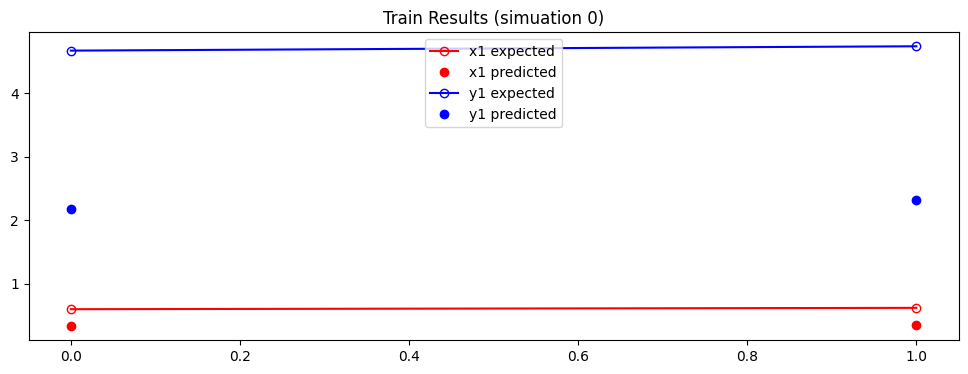

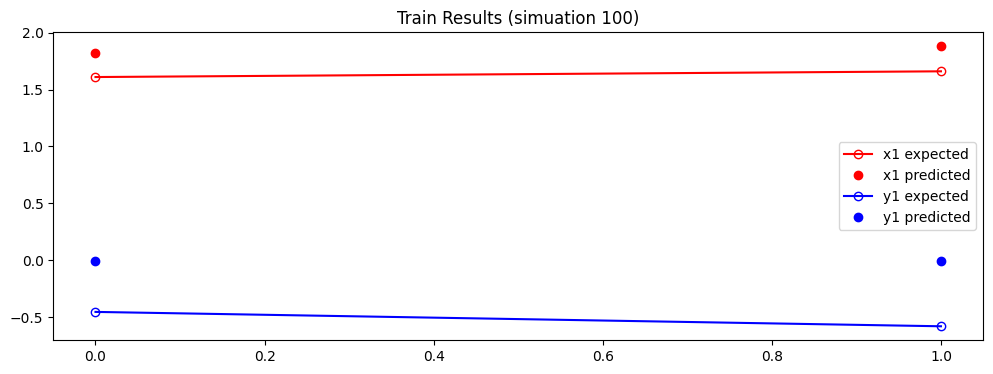

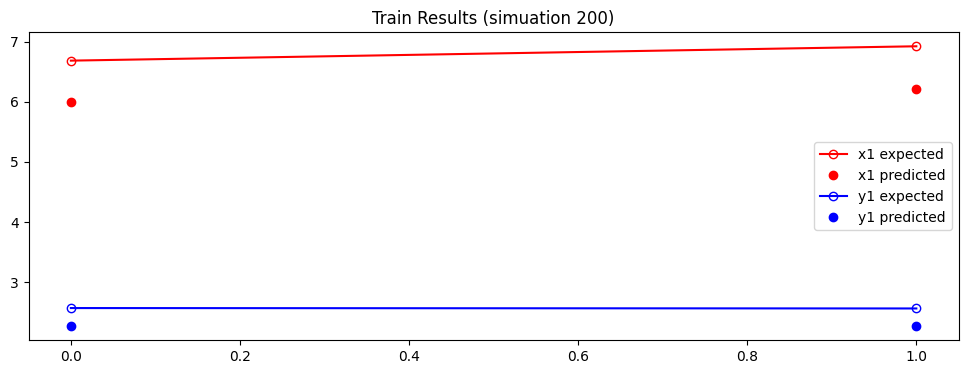

In [12]:
# display train results
import matplotlib.pyplot as plt

colours = ["r", "b", "g", "m", "c", "tab:orange", "tab:brown", "tab:pink", "tab:gray"]
data_files = ["x1", "y1"]
for i in [0, 100, 200]: # select batches
    for d, name in enumerate(data_files):
    
        plt.figure(i, figsize=(12, 4))
        plt.plot( y_test[i,:,d], "-o",fillstyle="none", color=colours[d], label=f'{name} expected')
        plt.plot( output[i,:,d] , "o", color=colours[d], label=f'{name} predicted')
        
        plt.title(f"Train Results (simuation {i})")
        plt.legend()